In [1]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.combine import SMOTEENN
from sklearn.metrics import f1_score

In [2]:
#Importing the dataset
df = pd.read_csv(r"C:\Users\HP\Documents\Fraud Detection Model\creditcard.csv")

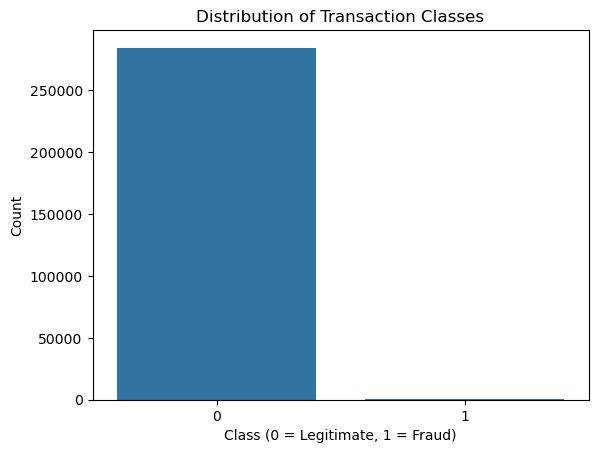

In [3]:
sns.countplot(x='Class', data=df)
plt.title("Distribution of Transaction Classes")
plt.xlabel("Class (0 = Legitimate, 1 = Fraud)")
plt.ylabel("Count")
plt.show()

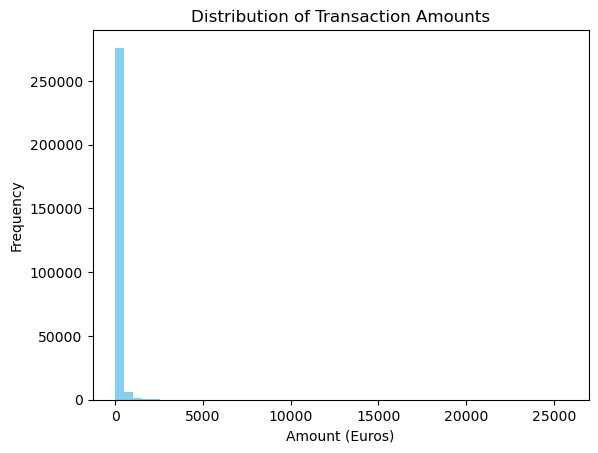

In [4]:
plt.hist(df['Amount'], bins=50, color='skyblue')
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Amount (Euros)")
plt.ylabel("Frequency")
plt.show()

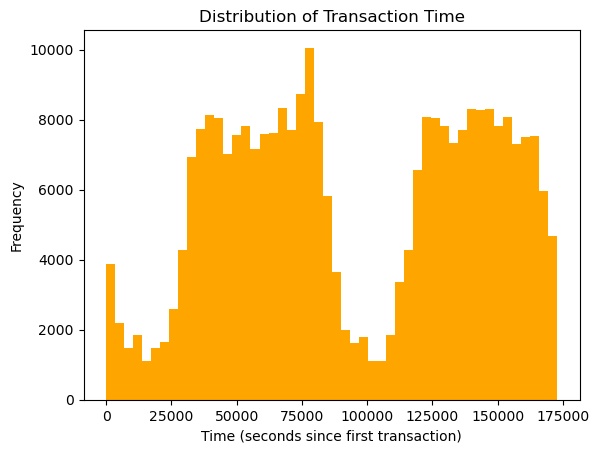

In [5]:
plt.hist(df['Time'], bins=50, color='orange')
plt.title("Distribution of Transaction Time")
plt.xlabel("Time (seconds since first transaction)")
plt.ylabel("Frequency")
plt.show()

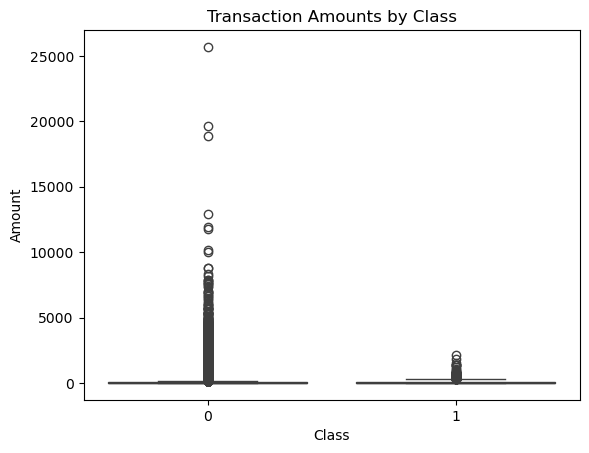

In [6]:
sns.boxplot(x='Class', y='Amount', data=df)
plt.title("Transaction Amounts by Class")
plt.xlabel("Class")
plt.ylabel("Amount")
plt.show()

In [7]:
#Converting Time to Hours of the Day
df['Hour'] = (df['Time'] // 3600) % 24
df.drop('Time', axis=1, inplace=True) 

In [8]:
#Scaling the Amount column
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

In [9]:
#Defining Features and Target
X = df.drop('Class', axis=1)
y = df['Class']

In [10]:
#Train-Test Data Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [11]:
#SMOTE-ENN
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

print(pd.Series(y_resampled).value_counts())

Class
1    199020
0    198641
Name: count, dtype: int64


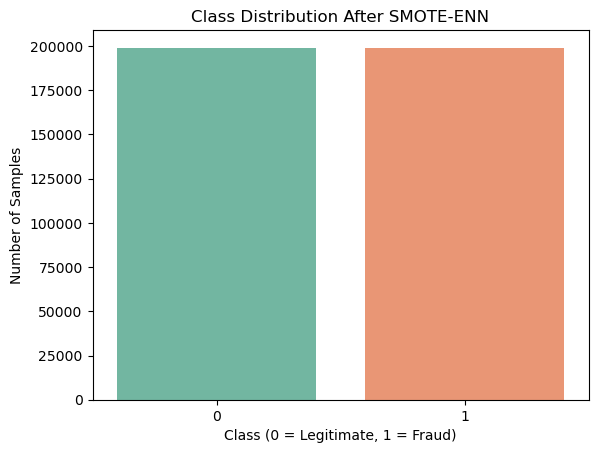

In [12]:
from collections import Counter

# Convert resampled target to DataFrame
resampled_df = pd.DataFrame(y_resampled, columns=['Class'])

sns.countplot(x='Class', hue='Class', data=resampled_df, palette='Set2', legend=False)
plt.title('Class Distribution After SMOTE-ENN')
plt.xlabel('Class (0 = Legitimate, 1 = Fraud)')
plt.ylabel('Number of Samples')
plt.show()

In [13]:
#Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_resampled, y_resampled)

LogisticRegression(max_iter=1000)

In [14]:
#Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [10]:
#Using the test data to check the evaluation of the Models
y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)

print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr))

print("Random Forest:")
print(classification_report(y_test, y_pred_rf))

Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85295
           1       0.06      0.89      0.11       148

    accuracy                           0.97     85443
   macro avg       0.53      0.93      0.55     85443
weighted avg       1.00      0.97      0.99     85443

Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.80      0.79      0.80       148

    accuracy                           1.00     85443
   macro avg       0.90      0.90      0.90     85443
weighted avg       1.00      1.00      1.00     85443



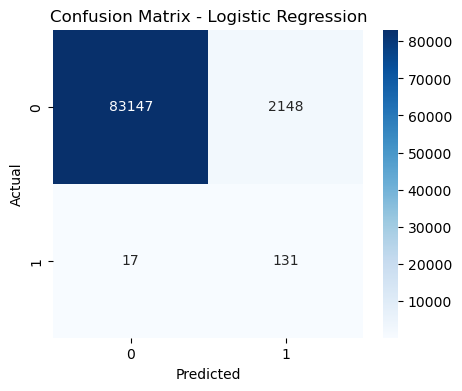

In [11]:
# Logistic Regression Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(5,4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

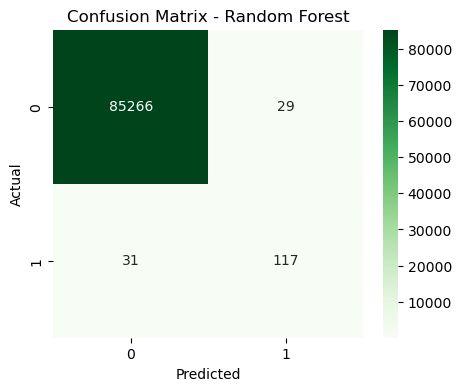

In [12]:
# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

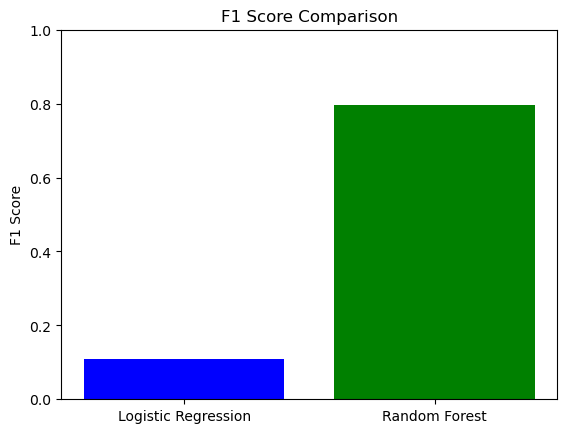

In [13]:
#Bar Chart of F1-Scores
f1_lr = f1_score(y_test, y_pred_lr)
f1_rf = f1_score(y_test, y_pred_rf)

plt.bar(['Logistic Regression', 'Random Forest'], [f1_lr, f1_rf], color=['blue', 'green'])
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison')
plt.ylim(0, 1)
plt.show()

In [14]:
#ROC-AUC
roc_auc_lr = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
roc_auc_rf = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
print("ROC-AUC (LR):", roc_auc_lr)
print("ROC-AUC (RF):", roc_auc_rf)

ROC-AUC (LR): 0.9687950245808268
ROC-AUC (RF): 0.9618009753114389


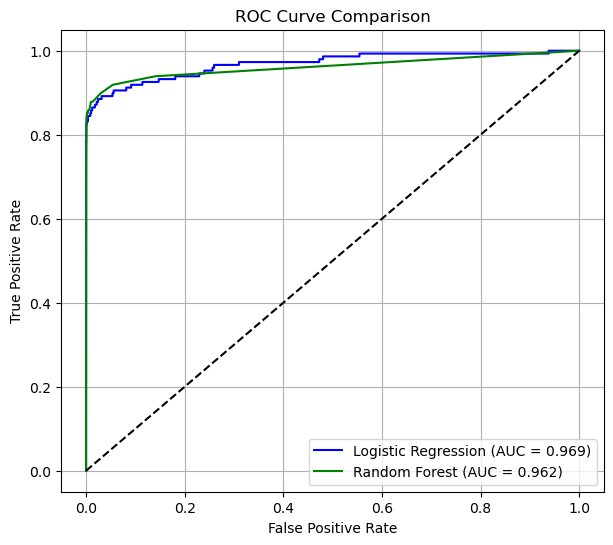

In [15]:
# LR ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
auc_lr = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])

# RF ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
auc_rf = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])

# Plot
plt.figure(figsize=(7,6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.3f})", color='blue')
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})", color='green')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
#Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf, X_resampled, y_resampled, cv=cv, scoring='f1')
print("5-Fold CV F1 Scores:", scores)

5-Fold CV F1 Scores: [0.99996232 1.         0.9999372  0.99984928 0.99998744]


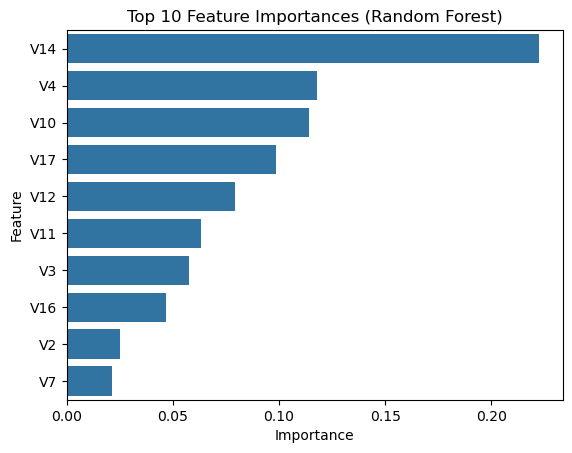

In [17]:
#Feature Importance
importances = rf.feature_importances_
feat_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_imp_df.sort_values('Importance', ascending=False, inplace=True)

# Plot
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(10))
plt.title('Top 10 Feature Importances (Random Forest)')
plt.show()

In [18]:
import joblib
joblib.dump(rf, 'rf_model.pkl')
joblib.dump(lr, 'lr_model.pkl')


['lr_model.pkl']